In [40]:
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import numpy as np
import random
import torch
from torch.utils.tensorboard import SummaryWriter
import torch.utils.data as Data
from torch import nn
import torch.nn.functional as F
from mymodel import *
from tqdm import tqdm
plt.rcParams['font.family'] = 'SimHei' 
plt.rcParams['axes.unicode_minus'] = False
t = np.linspace(0,20,100)
a=np.array([0.9,0.2,0.5,0.3,0.2])
noise=0.0
BATCH_SIZE=10
k=100
x=[]
y=[]

In [41]:
for i in range(1000):
    re=np.random.random()
    re=0.5
    u0=np.array([re,1-re,0,0])
    # a0=a+np.random.uniform(0, 0.1, (len(a)))
    a0=a
    data=REIS(t,u0,a0,noise)
    x.append(u0.tolist())
    y.append(data[1:].tolist())
x=torch.tensor(x).to(torch.float32)
y=torch.tensor(y).to(torch.float32)*k
torch_dataset = Data.TensorDataset(x, y)
loader = Data.DataLoader(
    # 从数据库中每次抽出batch size个样本
    dataset=torch_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
)

In [42]:
import torch
from torch.utils.tensorboard import SummaryWriter
from torch import nn
import torch.nn.functional as F

def train(loader, model, loss_fn, optimizer):
    """
        训练网络
        输入:
            train_dataloader:   训练集的dataloader
            model:              网络模型
            loss_fn:            损失函数
            optimizer:          优化器
        """
    # 切换到train模式
    model.train()
    # 遍历dataloader
    train_step=0
    best=1000
    loop = tqdm(enumerate(loader), total =len(loader))
    for step,(x,y) in loop:
        
        # 输入数据到模型里得到输出
        pred = model(x)
        # 计算输出和标签的loss
        l=torch.zeros(x.shape)
        loss = loss_fn(pred, y)
        # 反向推导
        optimizer.zero_grad()
        loss.backward()
        # 步进优化器
        optimizer.step()
        los=float(loss)
        if los<best:
            torch.save(model.state_dict(), "./data/R_model_parameter.pkl")
            best=los
        # print(los,best)
        train_step+=1
        loop.set_postfix(loss=los,best=best)

        
class net(nn.Module):
    def __init__(self, x_length,a_length,days):
        super().__init__()
        self.days=days
        self.blo_x=block_x(x_length,a_length)
        self.blo_x.load_state_dict(torch.load("./data/random_model_parameter.pkl"))
        freeze(self.blo_x)
        self.blo_a=block_a(x_length,a_length)
    def forward(self, x):
        out=[]
        for i in range(self.days):
            a=self.blo_a(x)
            day=self.blo_x(torch.cat((x,a),dim=1))
            out.append(day)
            x=day/k
        return torch.stack(out,dim=1)
module = net(4,5,99)
# 损失函数
loss_fn = nn.MSELoss()
# 优化器
learning_rate = 1e-8
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, module.parameters()))
# optimizer = torch.optim.SGD(module.parameters(), lr=learning_rate)
# 训练的轮数
epoch = 1
# 储存路径
work_dir = './ResNet'
# 添加tensorboard
writer = SummaryWriter("{}/logs".format(work_dir))
# 冻结网络层

100%|█████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 16.93it/s, best=1.3, loss=1.3]


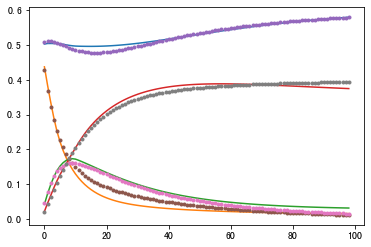

In [43]:
for i in range(5):
    train(loader,module, loss_fn, optimizer)
module.load_state_dict(torch.load("./data/R_model_parameter.pkl"))
x=torch.tensor([u0]).to(torch.float32)
plt.plot((module(x)/k).tolist()[0])
plt.plot((y[0]/k).tolist(),'.')
plt.show()

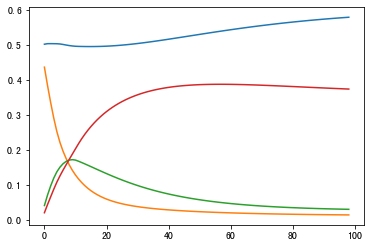

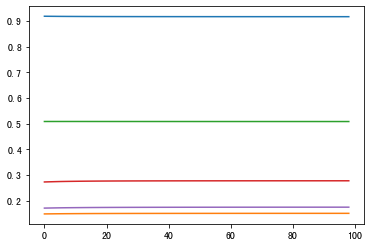

array([ 0.01649127, -0.04937438,  0.00817561, -0.02259027, -0.02533395])

In [44]:
x=torch.tensor([u0]).to(torch.float32)
out=[]
out_a=[]
days=99
for i in range(days):
    a=module.blo_a(x)
    day=module.blo_x(torch.cat((x,a),dim=1))
    out.append(day)
    out_a.append(a)
    x=day/k
plt.plot((torch.stack(out,dim=1)/k).tolist()[0])
plt.show()
plt.plot((torch.stack(out_a,dim=1)).tolist()[0])
plt.show()
out_a[-1][0].detach().numpy()-np.array([0.9,0.2,0.5,0.3,0.2])